# Imports

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
# to prevent to restart kernel when any changes are made to any imported file
%reload_ext autoreload
%autoreload 2

# to import any file from some other directory

# to stop printing warnings
import warnings
warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
warnings.warn = warn
    
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 20000)
pd.set_option('display.max_colwidth', -1)

# to increase cells width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# to enable collapsible Headings and Functions
# !pip install jupyter_contrib_nbextensions
# !jupyter contrib nbextension install --user
# !jupyter nbextensions_configurator enable --user
# !jupyter nbextension enable codefolding/main
# search collapsible to enable

# enable dark theme
# !pip install jupyterthemes
# !jt -t monokai

# monokai
# solarizedd
# !jt -r
import numpy as np
import pandas as pd
import sys, os
from datetime import datetime, timedelta
import requests
import json
import timeit
from datetime import datetime
import os.path, time
from datetime import datetime, timedelta
from threading import Timer
import pdb, random
from sklearn.base import clone

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from pprint import pprint
from fastai_utils import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

%matplotlib inline

# from fastai.imports import *
# from fastai.structured import *
# from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.ensemble import forest
from pandas_profiling import ProfileReport
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import statistics as stats

In [7]:
def split_dt(df, y, trn_split, vld_split=None):
    df.rename(columns={"saleYear": "year", "saleMonth": "month", "saleDay": "day"}, inplace=True)
    df["date"]=pd.to_datetime(df[["year", "month", "day"]])
    
    msk=df.date<trn_split
    X_train, y_train = df.drop(columns=["date"], axis=1)[msk],  y[msk]
    X_valid, y_valid = df.drop(columns=["date"], axis=1)[~msk], y[~msk]
    print("Train: ", X_train.shape); print("Valid: ", X_valid.shape)
    return X_train, y_train, X_valid, y_valid




In [8]:
PATH = "./bulldozers/"

In [9]:
!ls {PATH}

Data Dictionary.xlsx  TrainAndValid.7z	 ValidSolution.csv
Machine_Appendix.csv  TrainAndValid.csv  bluebook-for-bulldozers.zip
Test.csv	      TrainAndValid.zip  bulldozers_raw.pkl
Train.7z	      Valid.7z		 keep_cols.npy
Train.csv	      Valid.csv		 median_benchmark.csv
Train.zip	      Valid.zip		 random_forest_benchmark_test.csv


# Get data

In [10]:
data = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])
data.shape

(401125, 53)

In [11]:
df=data.copy()
df.shape

(401125, 53)

# Split

In [22]:
df.saledate.min(), df.saledate.max()

(Timestamp('1989-01-17 00:00:00'), Timestamp('2011-12-30 00:00:00'))

### Train/Test split

In [23]:
trainDF=df.loc[df.saledate <= "2011-10-30"]
testDF =df.loc[df.saledate >= "2011-11-01"]

trainDF.shape, testDF.shape

((395369, 53), (5754, 53))

### Train/Valid split

In [24]:
# since train/valid distribution will keep on changing along the experiment

train=trainDF.loc[trainDF.saledate  <  "2011-09-01"].sort_values(["saledate"])
valid=trainDF.loc[(trainDF.saledate >= "2011-09-01") & (trainDF.saledate < "2011-11-01")].sort_values(["saledate"])

train.shape, valid.shape

((390213, 53), (5156, 53))

# Preprocessing

In [25]:
def preprocess(train, valid, test):    
    add_datepart(train,  'saledate')
    add_datepart(valid,  'saledate')
    add_datepart(test, 'saledate')
    train_cats(train)
    train_cats(valid)
    train_cats(test)

    df_trn, y_trn, nas = proc_df(train, 'SalePrice')
    df_vld, y_vld, nas = proc_df(valid, 'SalePrice', na_dict=nas)
    df_ts, y_ts,   nas = proc_df(test, 'SalePrice', na_dict=nas)

    print("TRAIN: ", df_trn.shape, y_trn.shape)
    print("VALID: ", df_vld.shape, y_vld.shape)
    print("TEST: ",  df_ts.shape, y_ts.shape)
    
    return df_trn, y_trn, df_vld, y_vld, df_ts, y_ts, nas

In [26]:
# since testDF will remain same throughout experiment, so we will use the initial name testDF for test data

df_trn, y_trn, df_vld, y_vld, df_ts, y_ts, nas=preprocess(train, valid, testDF)


TRAIN:  (390213, 66) (390213,)
VALID:  (5156, 66) (5156,)
TEST:  (5754, 66) (5754,)


### Check Validation Set Size

1. Train 5 models with same params.  
2. Get valid score on same valid set  
3. Get standard deviation of these 5 numbers  
4. If std. dev is small enough then keep on with the valid set, else increase valid set size or or use cross-validation

In [36]:
set_rf_samples(5000)

In [37]:
n_iters=5

scores=[]
for i in range(1,n_iters+1):
    print(f"{i}/{n_iters}", end="\r")
    rf = RandomForestRegressor(n_jobs=-1).fit(df_trn, y_trn)
    scores.append(rf.score(df_vld, y_vld))

stats.stdev(scores)

0.006031572881623163

# Modelling

In [29]:
all_preds=[]

In [30]:
# _, _, X_sample, y_sample=split_dt(X_train, y_train, "2011-01-01")


In [31]:
def get_scores(m, xtrn, ytrn, xvld, yvld, xts, yts):
    """
    m: sklearn's model to train
    """
    
    m_trn=clone(m)
    m_ts=clone(m_trn)

    # 1. train on training set
    m_trn.fit(xtrn, ytrn)

    # 2. get score on valid_set
    vld_scr=m_trn.score(xvld, yvld)

    # 3.  train on valid+train set
    
    # 3.1.merged x_train+x_valid 
    x_merged=pd.concat([xtrn,xvld], axis=0)
    
    # 3.2.merged y_train+y_valid 
    y_merged=pd.concat([ytrn,yvld], axis=0)
    
    # 3.3.train on merged(train+valid) data
    m_ts.fit(x_merged, y_merged)
    
    # 4. get score on test_set
    ts_scr=m_ts.score(xts, yts)

    return vld_scr, ts_scr

In [37]:
X_sample, y_sample=df_trn.tail(20000), y_trn.tail(20000)

### Logistic Regressionn

In [35]:
%%time 
lgr = LogisticRegression(random_state=0, n_jobs=-1)

vld_scr, ts_scr=get_scores(lgr, X_sample, y_sample, df_vld, y_vld, df_ts, y_ts)

all_preds.append({"name": "lgr", "vld_scr": vld_scr, "ts_scr": ts_scr})

CPU times: user 898 ms, sys: 580 ms, total: 1.48 s
Wall time: 7min 12s


In [36]:
all_preds

[{'name': 'lgr', 'vld_scr': 0.01, 'ts_scr': 0.0},
 {'name': 'lgr',
  'vld_scr': 0.01590380139643134,
  'ts_scr': 0.017900590893291622}]

### SVR

In [38]:
%%time
svr = SVR(C=1.0, epsilon=0.2)

vld_scr, ts_scr=get_scores(svr, X_sample, y_sample, df_vld, y_vld, df_ts, y_ts)

all_preds.append({"name": "svr", "vld_scr": vld_scr, "ts_scr": ts_scr})

CPU times: user 5min 56s, sys: 617 ms, total: 5min 56s
Wall time: 5min 59s


In [39]:
all_preds

[{'name': 'lgr', 'vld_scr': 0.01, 'ts_scr': 0.0},
 {'name': 'lgr',
  'vld_scr': 0.01590380139643134,
  'ts_scr': 0.017900590893291622},
 {'name': 'svr',
  'vld_scr': -0.08851987277121952,
  'ts_scr': -0.12250931651635089}]

### RF 

In [40]:
%%time
rf = RandomForestRegressor(n_jobs=-1)

vld_scr, ts_scr=get_scores(rf, X_sample, y_sample, df_vld, y_vld, df_ts, y_ts)

all_preds.append({"name": "rf", "vld_scr": vld_scr, "ts_scr": ts_scr})

CPU times: user 1min 41s, sys: 838 ms, total: 1min 42s
Wall time: 29.3 s


In [41]:
all_preds

[{'name': 'lgr', 'vld_scr': 0.01, 'ts_scr': 0.0},
 {'name': 'lgr',
  'vld_scr': 0.01590380139643134,
  'ts_scr': 0.017900590893291622},
 {'name': 'svr',
  'vld_scr': -0.08851987277121952,
  'ts_scr': -0.12250931651635089},
 {'name': 'rf', 'vld_scr': 0.5267276646441512, 'ts_scr': 0.8212125387320378}]

## Plot

In [53]:
result_df=pd.DataFrame(all_preds)
result_df.sort_values(["vld_scr"], inplace=True)
result_df.to_pickle("/tmp/all_preds.pkl")




In [60]:
result_df

,name,vld_scr,ts_scr
2,svr,-0.088520,-0.122509
1,lgr,0.015904,0.017901
3,rf,0.526728,0.821213


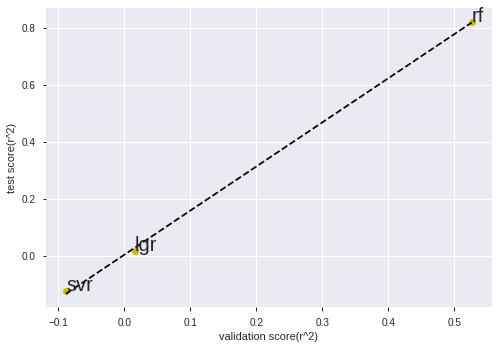

In [70]:
x,y,z=result_df.vld_scr.tolist(), result_df.ts_scr.tolist(), result_df.name.tolist()

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 

plt.plot(x, y, 'yo', x, poly1d_fn(x), '--k')
plt.xlabel("validation score(r^2)"); plt.ylabel("test score(r^2)")
for i, txt in enumerate(z):
    plt.annotate(txt, (x[i], y[i]), size=20)


In [71]:
# as our valid and test scores are aligned, so our validation set selection is good. This technique is very useful for kaggle
# competitions where test scores are kaggle scores after submission.